<center><h1>Experiments on SC09 Dataset</h1></center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile
import os

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Loading the Pre-Trained Model

We trained the model using `train_sc09.py` script. The following function will load the model and plot the losses.

In [4]:
def load_model(model, name, _epoch=None):
    global epoch, device, model_name, model_folder
    model_name = name
    model_folder = "./models/" + name

    with open(os.path.join(model_folder, "train_loss.txt"), 'r') as f:
        train = [float(i.strip()) for i in f.readlines()]

    with open(os.path.join(model_folder, "validation_loss.txt"), 'r') as f:
        valid = [float(i.strip()) for i in f.readlines()]

    plt.title(label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train)
    plt.plot(valid)

    epoch = len(train) if _epoch is None else _epoch
    checkpoint_filename = os.path.join(model_folder, f"epoch{epoch:04d}.pt")
    print("Loading model:", checkpoint_filename)
    checkpoint = torch.load(checkpoint_filename, map_location=device)

    return model.load_state_dict(checkpoint["model_state"])

## NLL Test

We want to compute negative log likelihood (NLL) values on the test dataset.

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [5]:
test_dataset = SC09("./datasets/sc09/test", device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def test_nll(model):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        nll = 0.0
        for x, y in tqdm(test_dataloader, leave=False):
            y_hat = model(x)
            nll += criterion(y_hat.view(-1, 256), y.view(-1))
        nll /= len(test_dataloader)

        print("Average NLL:", nll.item())
        print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
        print("Average NLL converted to probability:", (-nll).exp().item())

len(test_dataset)

WAV files in directory: 4107
318 WAV file(s) were discarded because they were not 1 second long.


3789

# 8-Layer SaShiMi with GLU

Let's load the pre-trained model. Note that you should have downloaded this model using `download_data.sh`.
Note that there are other pre-trained models in `models` folder.

In [6]:
model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000,
    block_count=8,
    block_class=S4BlockGLU,
    encoder=Embedding(256, 64),
).to(device)

print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 6377880
Parameters to be learned: 6377880


Loading model: ../models/sc09/epoch0040.pt


<All keys matched successfully>

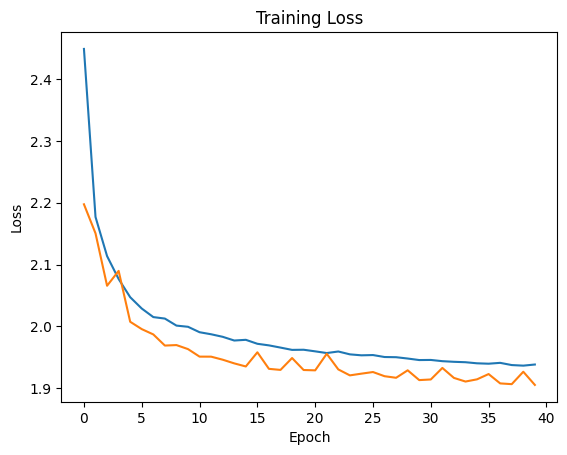

In [7]:
load_model(model, "sc09")

In [8]:
test_nll(model)

  0%|          | 0/3789 [00:00<?, ?it/s]

Average NLL: 1.9091062545776367
Average NLL in base 2: 2.754258155822754
Average NLL converted to probability: 0.14821279048919678


# Sampling

After loading a model, you can use the following code block to generate 32 samples at once and save them.

In [9]:
seed = 42
torch.manual_seed(seed)
model.eval()
with torch.no_grad():
    gen = generate_audio_sample(model, 16000, batch_size=32)
    gen = mu_law_decoding(gen, 256).cpu()

dirname = "outputs/" + model_name
if not os.path.exists(dirname):
    os.makedirs(dirname)

for i, g in enumerate(gen):
    wavfile.write(f"{dirname}/epoch{epoch:04d}-seed{seed}-{i}.wav", 16000, g.numpy())

  0%|          | 0/16000 [00:00<?, ?it/s]

Let's listen to the generated samples.

In [10]:
selected_index = 0

In [ ]:
selected = gen[selected_index]
print("Sample", selected_index)
selected_index = (selected_index + 1) % gen.size(dim=0)
plt.figure()
plt.plot(selected)
ipd.Audio(selected.numpy(), rate=16000)

You can run the previous block repeatedly to switch to the next sample.